### I) Loading data and preparing dataset - full scope - automated clustering valuation

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
import itertools
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")
path_dump = path_project / Path("dump")

In [3]:
# loading cdv data
file = path_data / Path("felix.csv")
with Path.open(file, 'rb') as fp:
    cdv = pd.read_csv(fp,  encoding='cp1252',low_memory=False, index_col = 0)
# loadind cdv data without format
file = path_data / Path("felix_ssfmt.csv")
with Path.open(file, 'rb') as fp:
    cdv_ssfmt = pd.read_csv(fp,  encoding='cp1252',low_memory=False, index_col = 0)
    # loading MergeCommunesEnvi data
file = path_data / Path("MergeCommunesEnvi.csv")
with Path.open(file, 'rb') as fp:
    MergeCommunesEnvi = pd.read_csv(fp,  encoding='cp1252',low_memory=False, sep=';', index_col = 1)

In [4]:
# load various variable set
filename = path_dump / Path("dict_var_groups.sav")
with open(filename, 'rb') as fp:
     dict_var_groups = pickle.load(fp)

#scope_2017_2018_ext_var = dict_var_groups['scope_2017_2018_ext_var']
#scope_2017_2018_var = dict_var_groups['scope_2017_2018_var']

pred_var = dict_var_groups['pred_var']
com_var = dict_var_groups['com_var']
tech_var = dict_var_groups['tech_var']
text_var = dict_var_groups['text_var']
bizz_var = dict_var_groups['bizz_var']
cat_var = dict_var_groups['cat_var']
cat_max9_var = dict_var_groups['cat_max9_var']
cat_min10_var = dict_var_groups['cat_min10_var']
quant_var = dict_var_groups['quant_var']

In [5]:
scope = dict_var_groups['cdv_2015_2018_var']
len(scope)

267

In [6]:
dict_var_groups.keys()

dict_keys(['cdv_2015_var', 'cdv_2016_var', 'cdv_2017_var', 'cdv_2018_var', 'cdv_2015_2018_var', 'cdv_2016_2018_var', 'cdv_2017_2018_var', 'pred_var', 'tech_var', 'com_var', 'text_var', 'bizz_var', 'cat_var', 'cat_max9_var', 'cat_min10_var', 'quant_var', 'commune_var', 'scope_2015_var', 'scope_2016_var', 'scope_2017_var', 'scope_2018_var', 'scope_2015_2018_var', 'scope_2016_2018_var', 'scope_2017_2018_var', 'indiv_semi_act_var', 'indiv_act_var', 'admin_semi_act_var', 'admin_act_var', 'exclusion', 'usual_common_scope'])

In [7]:
exclusion = com_var | tech_var | bizz_var | text_var 
scope_kept = scope - exclusion

cat_var_kept = cat_max9_var & scope_kept
scope_quant_var = (quant_var & scope_kept) 
quant_null = np.sum(MergeCommunesEnvi.loc[:,scope_quant_var].isnull())
quant_var_kept = set(quant_null[quant_null < 200].index)

print(f"Out of {MergeCommunesEnvi.shape[1]} variable {len(scope)} \
are used in 2017 and 2018 ")
print(f"{len(scope & exclusion)} of 'technical' variable \
such as 'inseenum' are excluded ")
print(f"{len(scope_kept)} are remaining :")
print(f"\t{len(cat_var & scope_kept)} \
categorial variables : ")
print(f"\t\t{len(cat_max9_var & scope_kept)} \
with maximum 9 modalities  ")
print(f"\t\t{len(cat_min10_var & scope_kept)} \
with more modalities ... excluded")
print(f"\t{len(quant_var & scope_kept)} \
variables are quantitative ")
print(f"\t\t{len(quant_var_kept)} have less than 200 missing values")
print(f"\t\t{len(scope_quant_var)-len(quant_var_kept)} \
have more ... excluded")

scope = cat_var_kept | quant_var_kept

Out of 571 variable 267 are used in 2017 and 2018 
33 of 'technical' variable such as 'inseenum' are excluded 
234 are remaining :
	166 categorial variables : 
		151 with maximum 9 modalities  
		15 with more modalities ... excluded
	68 variables are quantitative 
		53 have less than 200 missing values
		15 have more ... excluded


In [10]:
#df = MergeCommunesEnvi.loc[MergeCommunesEnvi['ANNEEFUZ'].isin({2017,2018}),scope]
df = MergeCommunesEnvi.loc[:,scope]
df.loc[:,scope] = cdv_ssfmt.loc[:,scope]
df.loc[:,cat_var_kept - {"HEUREUX"}] = cdv.loc[:,cat_var_kept - {"HEUREUX"}]
print(f"\nFinal number of variable kept : {df.shape[1]}")


Final number of variable kept : 204


In [11]:
p = df.shape[1]
print(f"{p} columns out of which {len(cat_var_kept)-1} \
are corresponding to categorial features")

204 columns out of which 150 are corresponding to categorial features


In [12]:
df = pd.get_dummies(df, 
                    columns=cat_var_kept - {"HEUREUX"},
                    dummy_na = True,
                    drop_first=1)

In [13]:
q = df.shape[1]
print(f"{q} columns after encoding of {len(cat_var_kept)-1} categorial \
variables in {len(cat_var_kept)-1+q-p} binary variables \
(K-1 one hot encoding)")

607 columns after encoding of 150 categorial variables in 553 binary variables (K-1 one hot encoding)


In [14]:
df.shape

(11131, 607)

In [15]:
# encoding of "HEUREUX" '[nsp]'
df.loc[df["HEUREUX"]==5,"HEUREUX"]= None
df = df.loc[np.isfinite(df['HEUREUX']).index,:]


# treating remaining missing values
features = df.columns.drop(['HEUREUX'])
df_tmp = df.loc[:,set(features) | {"HEUREUX"}].dropna()

X = df_tmp.loc[:,features]
y = df_tmp["HEUREUX"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42
                                                   )

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: {y.shape[0]}\n\
- training set: {y_train.shape[0]}\n\
- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")
print(f"Number of class: {len(np.unique(y))}")
for c in np.unique(y):
    print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")

Number exemple: 10596
- training set: 8476
- test set: 2120
Number of features: p=606
Number of class: 4
class 1 : 1.8%
class 2 : 33.1%
class 3 : 49.1%
class 4 : 15.9%


### II) Feature selection

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


done in 18182.5 s
Optimal number of features : 156


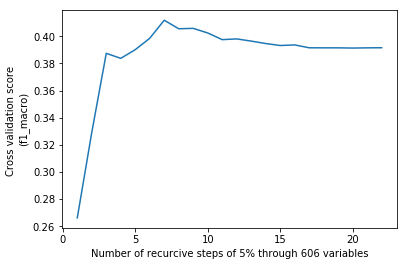

In [16]:
startTime = time.time()

scoring='f1_macro' 
step = 0.05

clf = LogisticRegression(C=1, 
                         penalty='l1', 
                         class_weight='balanced',
                         random_state=42)

rfecv = RFECV(estimator=clf, step=step, cv=StratifiedKFold(2),
              scoring=scoring)

rfecv.fit(X_train, y_train)
print(f"done in {time.time() - startTime:0.1f} s")
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel(f"Number of recurcive steps of {100*step:0.0f}% through {X_train.shape[1]} variables")
plt.ylabel(f"Cross validation score \n({scoring})")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [17]:
lasso_mask = rfecv.support_
X_train = X_train[:,lasso_mask]
X_test = X_test[:,lasso_mask]
print(f"Number of features: p={X_train.shape[1]}")

Number of features: p=156


In [18]:
lasso_features = set(df.columns.drop(['HEUREUX'])[lasso_mask])
lasso_features

{'ACTCONJ_Non, a travaillé mais ne travaille plus',
 'ACTCONJ_nan',
 'AGE',
 'AGE5',
 'AGGLO5_20 000 à 100 000 habitants',
 'AGGLO5_Plus de 100 000 habitants',
 'AGGLO9_100 000 à 200 000 habitants',
 'AGGLO9_50 000 à 100 000 habitants',
 'AGGLO9_Agglomération parisienne',
 'AGGLO9_Communes rurales',
 'AGGLO9_Plus de 200 000 habitants',
 'ASSO10_2_Non adhérent',
 'ASSO10_3',
 'ASSO11_3_Une',
 'ASSOAUTR_Oui',
 'ASSOAUTR_nan',
 'ASSOCONF_[Nsp]',
 'ASSOCULT_Oui',
 'ASSOHUMA_[Nsp]',
 'ASSOPARE_[Nsp]',
 'ASSOPOLI_[Nsp]',
 'ASSOSYND_Oui',
 'ASSOSYND_[Nsp]',
 'AUTREREV',
 'BANQEPA_Oui',
 'BANQEPA_[Nsp]',
 'BANQMOB_[Nsp]',
 'BANQVIE_[Nsp]',
 'CADVIE',
 'CADVIE3_Satisfait de son cadre de vie',
 'CDV5',
 'CDV5_4',
 'CHERCHEM_Oui',
 'CHOAVANT_[Nsp]',
 'CHOIXNUC_Sans avis',
 'CLASSESO_La classe moyenne supérieure',
 'CLASSESO_La classe populaire',
 'CLASSESO_Les défavorisés',
 'CLASSESO_Les gens aisés',
 'CLASSESO_Les privilégiés',
 'CONFENTR',
 'DEPLOG',
 'DEPLOG3_Une charge négligeable, supportab

### III) Model valuation

#### a) Random Forest

In [19]:
startTime = time.time()
n_estimators_range = [16,32,64,128,256]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, 
                    scoring='f1_macro', 
                    param_grid=param_grid)

grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in \
{time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \n\
F1 weighted Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Determination of optimal hyperparameters in 140.4 s
Optimal values are {'max_depth': 8, 'n_estimators': 128} 
F1 weighted Score of cross valdation 42.64%


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

f1 score class 'Jamais' : 30.0%
f1 score class 'Occasionnellement' : 58.2%
f1 score class 'Assez souvent' : 50.9%
f1 score class 'Très souvent' : 46.0%
Average scores :
f1 macro : 46.2659 %
f1 weighted : 52.1892 %
accuracy : 52.2642 %
Confusion matrix, without normalization
[[  9  23   2   3]
 [ 13 447 186  47]
 [  0 332 458 287]
 [  1  41  77 194]]
Normalized confusion matrix
[[ 0.24  0.62  0.05  0.08]
 [ 0.02  0.65  0.27  0.07]
 [ 0.    0.31  0.43  0.27]
 [ 0.    0.13  0.25  0.62]]


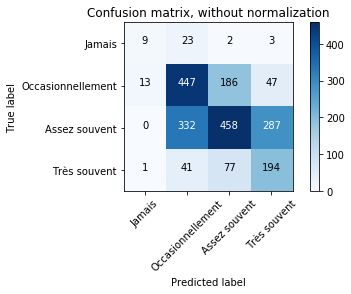

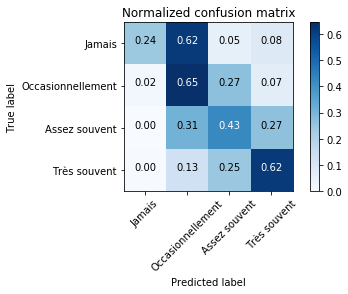

In [21]:
# Model evaluation
class_names = ["Jamais",
               "Occasionnellement",
               "Assez souvent",
               "Très souvent" ]
y_test_pred = clf.predict(X_test)
f1_scores = f1_score(y_test, y_test_pred, labels = [1,2,3,4], average=None)
for i,c in enumerate(class_names):
    print(f"f1 score class '{c}' : {100*f1_scores[i]:0.1f}%")
accuracy = clf.score(X_test, y_test)
f1_macro = f1_score(y_test, y_test_pred, average='macro')
f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
print(f"Average scores :\nf1 macro : {f1_macro*100:0.4f} %\n\
f1 weighted : {f1_weighted*100:0.4f} %\naccuracy : {accuracy*100:0.4f} %")

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# save performance
score_rf  = {
    'f1_scores' : f1_scores,
    'accuracy' : accuracy,
    'f1_macro' : f1_macro,
    'f1_weighted' : f1_weighted
}

### IV) Load, learn and valuate model on clusters

In [22]:
# loading cdv data
file = path_data / Path("clustTest1.csv")
with Path.open(file, 'rb') as fp:
    clustTest1 = pd.read_csv(fp,  encoding='utf-8',low_memory=False, sep=";", index_col = 0)

In [23]:
clustTest1.head(2)

,clust1,clust2,clust3,clust4,clust5
INTER6,,,,,
390001,1,4,5,1.0,2.0
390002,2,6,4,7.0,5.0


In [24]:
#score = dict()

n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)
params = {'max_features' :'sqrt', 
          'random_state' : 32, 
          'min_samples_split' : 2, 
          'class_weight' : 'balanced'
         }

score_clustering_methods = []
clustering_methods = clustTest1.columns[0:3]

for method in clustering_methods:
    print(f"\nAnalysis cluster method {method}")
    cluster_list = clustTest1[method].unique()
    print(f"liste of clusters : {cluster_list}")
    score_cluster = []
    for cluster in cluster_list:
        index_scope = clustTest1.loc[clustTest1[method]==cluster,:].index
        print(f"cluster {cluster} : {len(index_scope)} elements")
        
        # treating remaining missing values
        features = df.columns.drop(['HEUREUX'])[lasso_mask]
        df_tmp = df.loc[index_scope,set(features) | {"HEUREUX"}].dropna()

        X = df_tmp.loc[:,features]
        y = df_tmp["HEUREUX"]

        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.2, 
                                                            random_state=42
                                                           )

        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        print(f"Number exemple: {y.shape[0]}\n\
        - training set: {y_train.shape[0]}\n\
        - test set: {y_test.shape[0]}")
        print(f"Number of features: p={X_train.shape[1]}")
        print(f"Number of class: {len(np.unique(y))}")
        for c in np.unique(y):
            print(f"class {c:0.0f} : {100*np.sum(y==c)/len(y):0.1f}%")
            
            
        startTime = time.time()
        clf = RandomForestClassifier(**params)
        grid = GridSearchCV(clf, 
                            scoring='f1_macro', 
                            param_grid=param_grid)

        grid.fit(X_train, y_train)
        print(f"Optimal values are {grid.best_params_} \n\
        F1 weighted Score of cross valdation {100*grid.best_score_:0.2f}%")

        # Learning on full training set with optimals hyperparameters and score on test set
        params_opt = {'max_features' :'sqrt', 'random_state' : 32, 
                      'min_samples_split' : 2, 'class_weight' : 'balanced',
                      'n_estimators' : grid.best_params_['n_estimators'],
                      'max_depth' : grid.best_params_['max_depth']}
        clf = RandomForestClassifier(**params_opt).fit(X_train, y_train)

            
        y_test_pred = clf.predict(X_test)
        f1_scores = f1_score(y_test, y_test_pred, labels = [1,2,3,4], average=None)
        accuracy = clf.score(X_test, y_test)
        f1_macro = f1_score(y_test, y_test_pred, average='macro')
        f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
            
        res  = {'f1_scores' : f1_scores,
                'accuracy' : accuracy,
                'f1_macro' : f1_macro,
                'f1_weighted' : f1_weighted}
            
        cl = {'cluster' : cluster,
              'model' : 'RandomForestClassifier',
              'params' : params_opt,
              'metrics' : res
             }
         
        score_cluster.append(cl)
        
    d = {'clustering_method' : method,
         'cluster_scores' : score_cluster
        }
    score_clustering_methods.append(d) 


Analysis cluster method clust1
liste of clusters : [1 2 3 4 5 6]
cluster 1 : 295 elements
Number exemple: 289
        - training set: 231
        - test set: 58
Number of features: p=156
Number of class: 4
class 1 : 5.2%
class 2 : 41.2%
class 3 : 39.1%
class 4 : 14.5%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal values are {'max_depth': 4, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 35.95%
cluster 2 : 1729 elements
Number exemple: 1714
        - training set: 1371
        - test set: 343
Number of features: p=156
Number of class: 4
class 1 : 2.3%
class 2 : 37.8%
class 3 : 46.8%
class 4 : 13.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 42.48%
cluster 3 : 3633 elements
Number exemple: 3519
        - training set: 2815
        - test set: 704
Number of features: p=156
Number of class: 4
class 1 : 1.5%
class 2 : 32.9%
class 3 : 49.5%
class 4 : 16.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 42.28%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, war

cluster 4 : 218 elements
Number exemple: 214
        - training set: 171
        - test set: 43
Number of features: p=156
Number of class: 4
class 1 : 0.9%
class 2 : 27.1%
class 3 : 50.0%
class 4 : 22.0%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 2, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 48.03%
cluster 5 : 137 elements
Number exemple: 133
        - training set: 106
        - test set: 27
Number of features: p=156
Number of class: 4
class 1 : 3.0%
class 2 : 39.8%
class 3 : 43.6%
class 4 : 13.5%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anac

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 38.12%
cluster 6 : 24 elements
Number exemple: 23
        - training set: 18
        - test set: 5
Number of features: p=156


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anac

Number of class: 4
class 1 : 4.3%
class 2 : 43.5%
class 3 : 30.4%
class 4 : 21.7%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metri

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal values are {'max_depth': 8, 'n_estimators': 16} 
        F1 weighted Score of cross valdation 45.91%

Analysis cluster method clust2
liste of clusters : [4 6 5 1 3 2 7]
cluster 4 : 212 elements
Number exemple: 211
        - training set: 168
        - test set: 43
Number of features: p=156
Number of class: 4
class 1 : 8.1%
class 2 : 42.7%
class 3 : 32.2%
class 4 : 17.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Optimal values are {'max_depth': 2, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 44.80%
cluster 6 : 1137 elements
Number exemple: 1128
        - training set: 902
        - test set: 226
Number of features: p=156
Number of class: 4
class 1 : 1.8%
class 2 : 33.2%
class 3 : 48.2%
class 4 : 16.8%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 42.39%
cluster 5 : 750 elements
Number exemple: 742
        - training set: 593
        - test set: 149
Number of features: p=156
Number of class: 4
class 1 : 1.5%
class 2 : 32.7%
class 3 : 48.7%
class 4 : 17.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 48.97%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cluster 1 : 1257 elements
Number exemple: 1158
        - training set: 926
        - test set: 232
Number of features: p=156
Number of class: 4
class 1 : 1.9%
class 2 : 37.7%
class 3 : 47.5%
class 4 : 13.0%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 41.03%
cluster 3 : 1254 elements
Number exemple: 1235
        - training set: 988
        - test set: 247
Number of features: p=156
Number of class: 4
class 1 : 1.2%
class 2 : 31.5%
class 3 : 52.7%
class 4 : 14.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 36.51%
cluster 2 : 857 elements
Number exemple: 851
        - training set: 680
        - test set: 171
Number of features: p=156
Number of class: 4
class 1 : 1.6%
class 2 : 31.7%
class 3 : 49.6%
class 4 : 17.0%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 39.57%
cluster 7 : 569 elements
Number exemple: 567
        - training set: 453
        - test set: 114
Number of features: p=156
Number of class: 4
class 1 : 2.8%
class 2 : 43.0%
class 3 : 41.1%
class 4 : 13.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 40.83%

Analysis cluster method clust3
liste of clusters : [5 4 1 2 3]
cluster 5 : 373 elements
Number exemple: 372
        - training set: 297
        - test set: 75
Number of features: p=156
Number of class: 4
class 1 : 4.3%
class 2 : 41.4%
class 3 : 37.6%
class 4 : 16.7%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 2, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 35.93%
cluster 4 : 2682 elements
Number exemple: 2656
        - training set: 2124
        - test set: 532
Number of features: p=156
Number of class: 4
class 1 : 1.4%
class 2 : 34.2%
class 3 : 49.0%
class 4 : 15.3%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 128} 
        F1 weighted Score of cross valdation 47.06%
cluster 1 : 1593 elements
Number exemple: 1493
        - training set: 1194
        - test set: 299
Number of features: p=156
Number of class: 4
class 1 : 2.1%
class 2 : 34.8%
class 3 : 49.0%
class 4 : 14.1%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 4, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 39.99%
cluster 2 : 1246 elements
Number exemple: 1234
        - training set: 987
        - test set: 247
Number of features: p=156
Number of class: 4
class 1 : 1.8%
class 2 : 33.0%
class 3 : 48.6%
class 4 : 16.6%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 8, 'n_estimators': 64} 
        F1 weighted Score of cross valdation 37.88%
cluster 3 : 142 elements
Number exemple: 137
        - training set: 109
        - test set: 28
Number of features: p=156
Number of class: 4
class 1 : 5.8%
class 2 : 41.6%
class 3 : 40.9%
class 4 : 11.7%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

Optimal values are {'max_depth': 2, 'n_estimators': 32} 
        F1 weighted Score of cross valdation 30.76%


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
print(f"F1 macro on full dataset : {100*score_rf['f1_macro']:0.1f}%")
for score_method in score_clustering_methods:
    print(f"method {score_method['clustering_method']}:")
    average_score = 0
    for i, score_cluster in enumerate(score_method['cluster_scores']):
        print(f"cluster {score_cluster['cluster']}, f1 macro {100*score_cluster['metrics']['f1_macro']:0.1f}%")  
        average_score = average_score + score_cluster['metrics']['f1_macro']
    average_score = average_score / (i+1)
    print(f"average f1 macro on clusters {100*average_score:0.1f}%")  

F1 macro on full dataset : 46.3%
method clust1:
cluster 1, f1 macro 44.8%
cluster 2, f1 macro 38.1%
cluster 3, f1 macro 36.7%
cluster 4, f1 macro 44.7%
cluster 5, f1 macro 32.1%
cluster 6, f1 macro 76.2%
average f1 macro on clusters 45.4%
method clust2:
cluster 4, f1 macro 26.0%
cluster 6, f1 macro 46.9%
cluster 5, f1 macro 38.9%
cluster 1, f1 macro 29.7%
cluster 3, f1 macro 41.5%
cluster 2, f1 macro 36.4%
cluster 7, f1 macro 31.1%
average f1 macro on clusters 35.8%
method clust3:
cluster 5, f1 macro 44.0%
cluster 4, f1 macro 39.0%
cluster 1, f1 macro 41.4%
cluster 2, f1 macro 38.6%
cluster 3, f1 macro 34.0%
average f1 macro on clusters 39.4%
